Have trained a classifier following https://blog.machinebox.io/how-anyone-can-build-a-machine-learning-image-classifier-from-photos-on-your-hard-drive-very-5c20c6f2764f using my own bird data. Achieved an accuracy of 88% - but the first time I ran the script (different random selection of images) accuracy was about 92%, so clearly I am very sensitive to the images randomly selected and should add more images:
```
Correct:    180
Incorrect:  23
Errors:     0
Accuracy:   88.66995073891626%
```

https://machineboxio.com/docs/classificationbox

classificationbox is online learning (supervised learning), it works also with little data but it build the classifier function so it needs more data. for my bird monirtoring project my 2 classes would be bird/no_bird, and I just post the image data

Classifiers can be made to help solve a wide range of example use cases, for example:

* Learn about how your company is perceived by grouping tweets into positive and negative
* Automatically group photos of cats and dogs
* Group emails into spam and non-spam categories
* Build a classifier to detect the language of a piece of text based on previously taught examples

```
sudo docker pull machinebox/classificationbox

sudo docker run -p 8080:8080 -e "MB_KEY=$MB_KEY" machinebox/classificationbox
```
http://localhost:8080/

Note that if you restart classificationbox models will be lost

In [1]:
import requests
import curlify
import re
import json
import base64
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

def base64_encode_file(file_path):
    """
    Takes the path to an image and returns the base64 encoded
    image data as a string.
    """
    with open(file_path, "rb") as f:
        file_data = base64.b64encode(f.read()).decode('ascii')
    return file_data

In [2]:
IP =  'localhost'
#IP =  '192.168.0.30'
PORT = '8080'
CLASSIFIER = 'classificationbox'
CONFIDENCE = 80

MODELS_LIST_URL = 'http://{}:{}/{}/models'.format(IP, PORT, CLASSIFIER)
MODEL_CREATION_URL = 'http://{}:{}/{}/models'.format(IP, PORT, CLASSIFIER)
STATE_POST_URL = 'http://{}:{}/classificationbox/state'.format(IP, PORT)

Lets list my models

In [3]:
models_query = requests.get(MODELS_LIST_URL).json()

if models_query['success']:
    for model in models_query['models']:
        print(model['id'], model['name'])

5b0ce5d8023d4e35 5b0ce5d8023d4e35


In [4]:
models_query

{'success': True,
 'models': [{'id': '5b0ce5d8023d4e35', 'name': '5b0ce5d8023d4e35'}]}

I want the model which was generated by the GO script on my bird data

In [5]:
MODEL_ID = models_query['models'][0]['id']
MODEL_ID

'5b0ce5d8023d4e35'

In [6]:
MODEL_PREDICT_URL = 'http://{}:{}/{}/models/{}/predict'.format(IP, PORT, CLASSIFIER, MODEL_ID)
MODEL_STATS_URL = 'http://{}:{}/{}/models/{}/stats'.format(IP, PORT, CLASSIFIER, MODEL_ID)

MODEL_STATE_URL = 'http://{}:{}/classificationbox/state/{}'.format(IP, PORT, MODEL_ID)
MODEL_TEACH_URL = 'http://{}:{}/{}/models/{}/teach'.format(IP, PORT, CLASSIFIER, MODEL_ID)

Now lets see the stats on this model

In [7]:
model_stats = requests.get(MODEL_STATS_URL).json()
model_stats

{'success': True, 'predictions': 2, 'examples': 0, 'classes': []}

Lets make a prediction on a bird image

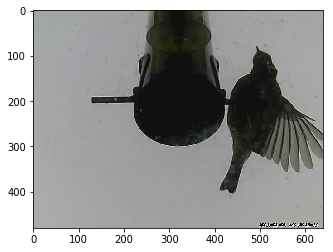

In [8]:
IMG_FILE = "bird_project/bird.jpg"
FIG_SIZE = (6, 4)

img = plt.imread(IMG_FILE)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.imshow(img);

In [9]:
MODEL_PREDICT_URL

'http://localhost:8080/classificationbox/models/5b0ce5d8023d4e35/predict'

## Predict via JSON encoded

In [10]:
predict_data  = {
    "inputs": [
        {"key": "image", "type": "image_base64", "value": base64_encode_file(IMG_FILE)}]}

try:
    response = requests.post(MODEL_PREDICT_URL, json=predict_data)
except ValueError:
    print("Classificationbox error: {}".format(response.json.text))
 #   response = {}

In [11]:
print(curlify.to_curl(response.request))

curl -X 'POST' -H 'Accept: */*' -H 'Accept-Encoding: gzip, deflate' -H 'Connection: keep-alive' -H 'Content-Length: 25235' -H 'Content-Type: application/json' -H 'User-Agent: python-requests/2.18.4' -d 'b'{"inputs": [{"key": "image", "type": "image_base64", "value": "/9j/4AAQSkZJRgABAQAAAQABAAD/4QCURXhpZgAATU0AKgAAAAgAAwEyAAIAAAAUAAAAXIdpAAQAAAABAAAAMogqAAgAAAABAAAAAAAAAAAAA5AAAAcAAAAEMDIyMJADAAIAAAAUAAAAcJIUAAMAAAAEAAAAhAAAAAAyMDE4OjAyOjAzIDE0OjQ3OjIzADIwMTg6MDI6MDMgMTQ6NDc6MjMAAgQA3wC0AQ7/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEA

In [12]:
requests.post(MODEL_PREDICT_URL, json=predict_data).text

'{\n\t"success": true,\n\t"classes": [\n\t\t{\n\t\t\t"id": "birds",\n\t\t\t"score": 0.915892\n\t\t},\n\t\t{\n\t\t\t"id": "not_birds",\n\t\t\t"score": 0.084108\n\t\t}\n\t]\n}'

In [13]:
requests.post(MODEL_PREDICT_URL, json=predict_data).status_code

200

In [14]:
def get_classes(classes_json):
    """Return the classes data."""
    classes_dict = {class_result['id']: round(class_result['score'] * 100.0, 2)
                    for class_result in classes_json}
    return classes_dict

In [16]:
classes = get_classes(response['classes'])
classes

TypeError: 'method' object is not subscriptable

In [ ]:
for key, value in classes.items():
    if value >= CONFIDENCE:
        print("{} with confidence {}".format(key, value))

Great! Successful prediction. Now lets try the not bird

In [ ]:
IMG_FILE = "not_bird.jpg"
FIG_SIZE = (6, 4)

img = plt.imread(IMG_FILE)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.imshow(img);

In [ ]:
predict_data  = {
    "inputs": [
        {"key": "image", "type": "image_base64", "value": base64_encode_file(IMG_FILE)}]}

requests.post(MODEL_PREDICT_URL, json=predict_data).json()

OK still correct, but obviously its easier to classify an image with a bird present. This is OK since I want the bird images and don't care about the not_bird

# Download model
We can download the model as a binary file. A `model_{model_id}.classificationbox` data file will be downloaded

In [ ]:
MODEL_STATE_URL # Pasting this in the browser will download the files

In [ ]:
%%time
response = requests.get(MODEL_STATE_URL)

In [ ]:
filename = "model_{}.classificationbox".format(MODEL_ID)
filename

In [ ]:
open(filename, 'wb').write(response.content)

In [ ]:
ls

# Upload model
Now lets upload the model having restarted connection box

In [ ]:
filename = '/Users/robincole/Documents/Data/Machinebox/classificationbox/birds.classificationbox'
model_data  = {"base64": base64_encode_file(filename)}
requests.post(STATE_POST_URL, json=model_data).json() # Default

## Class
Make a class wrapper

In [ ]:
CLASSIFIER = 'classificationbox'

class ClassificationboxEntity():
    """Perform an image classification."""

    def __init__(self, ip, port, camera_entity, model_id, model_name):
        """Initialise a classificationbox model entity."""
        self._base_url = "http://{}:{}/{}/".format(ip, port, CLASSIFIER)
        self._camera = camera_entity

        self._model_id = model_id
        self._model_name = model_name

        camera_name = camera_entity # split_entity_id(camera_entity)[1]
        self._name = "{} {} {}".format(
            CLASSIFIER, camera_name, model_name)
        
    @property
    def name(self):
        """Return the name of the sensor."""
        return self._name
    
    @property
    def device_state_attributes(self):
        """Return the classifier attributes."""
        return {
            'model_id': self._model_id,
            'model_name': self._model_name
            }
    

In [ ]:
entities = []

if models_query['success']:
    for model in models_query['models']:
        camera_entity = 'mock_cam'
        entity = ClassificationboxEntity(IP, PORT, camera_entity, model['id'], model['name'])
        entities.append(entity)

In [ ]:
entities[1].name

In [ ]:
entities[1].device_state_attributes

In [ ]:
try:
    response = requests.get(MODELS_LIST_URL, timeout=9).json()
except requests.exceptions.ConnectionError:
    _LOGGER.error("ConnectionError: Is %s running?", CLASSIFIER)

if response.staus_code == 200:
    print('success')

In [ ]:
requests.get(MODELS_LIST_URL, timeout=9).status_code

In [ ]:
MODELS_LIST_URL